# Proyecto 3: Movie Genre Classification
# Creación del Modelo

#### **Juan Camilo Florez 201620135**
#### **Fernando Perez 200222809**
#### **Jhon Florez 201920529**
#### **Angie Paola Chacón 201012536**


### **Importar librerias y base de datos *train* y *test***


In [1]:
#Importar librerías y cargar la base de datos
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
import nltk
from nltk.corpus import stopwords
from nltk  import word_tokenize
import string
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
english_stopwords = stopwords.words('english')
punctuation = string.punctuation

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
#Importación de las bases
dataTraining = pd.read_csv('https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass/raw/master/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)
dataTraining['base'] = 'training'
datakaggle = pd.read_csv('https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass/raw/master/datasets/dataTesting.zip', encoding='UTF-8', index_col=0)
datakaggle['base'] = 'kaggle'
dataTraining = dataTraining.reset_index(drop=True)


In [3]:
print('Variables BD kaggle', datakaggle.columns)
print('Variables BD train',dataTraining.columns)

Variables BD kaggle Index(['year', 'title', 'plot', 'base'], dtype='object')
Variables BD train Index(['year', 'title', 'plot', 'genres', 'rating', 'base'], dtype='object')


Se observa que la base de datos de kaggle no cuenta con la información de rating de la película. Por lo tanto, las variables de interés a explorar para el desarrollo del modelo son *plot*, *title* y *year*. 

In [4]:
print('Resumen base training')
print(dataTraining.info())

print('Resumen base kaggle')
print(datakaggle.info())


Resumen base training
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7895 entries, 0 to 7894
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    7895 non-null   int64  
 1   title   7895 non-null   object 
 2   plot    7895 non-null   object 
 3   genres  7895 non-null   object 
 4   rating  7895 non-null   float64
 5   base    7895 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 370.2+ KB
None
Resumen base kaggle
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3383 entries, 1 to 11275
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    3383 non-null   int64 
 1   title   3383 non-null   object
 2   plot    3383 non-null   object
 3   base    3383 non-null   object
dtypes: int64(1), object(3)
memory usage: 132.1+ KB
None


### **Análisis exploratorio de la base de datos**

**Datos faltantes**

In [5]:
#identificar si hay valores NAN en los datos TRAINING
print(dataTraining.isna().sum())
print(dataTraining.shape)

year      0
title     0
plot      0
genres    0
rating    0
base      0
dtype: int64
(7895, 6)


In [6]:
#identificar si hay valores NAN en los datos KAGGLE
print(datakaggle.isna().sum())
print(datakaggle.shape)

year     0
title    0
plot     0
base     0
dtype: int64
(3383, 4)


Ninguna de las bases de datos tienen valores faltantes las variables de interés.

**Histograma de la frecuencia de las palabras de la variable plot en base train**

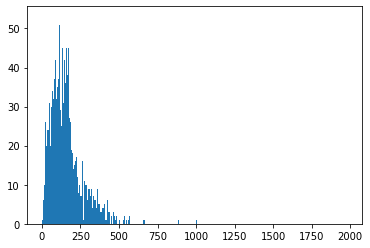

count    7895.000000
mean      160.029006
std       106.253661
min         1.000000
25%        88.000000
50%       141.000000
75%       202.000000
max      1975.000000
Name: totalwords, dtype: float64
484.119999999999


<Figure size 1440x720 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import numpy as np 

#Variable que cuenta el número de palabras que contiene el plot
dataTraining['totalwords'] = dataTraining['plot'].str.count(' ') + 1
x = dataTraining['totalwords'].sort_values()
n_bins = 1980
#Histograma de la cantidad de palabras que contiene cada plot
plt.hist(x, bins=n_bins)
plt.show()
plt.figure(figsize=(20,10))
print(dataTraining['totalwords'].describe())
print(np.quantile(dataTraining['totalwords'], .99))


In [8]:
#ista de películas con menor y mayor cantidad de palabras
dataTraining.sort_values('totalwords',  ascending=True)[:20]
len(dataTraining)

7895

In [9]:
dataTraining = dataTraining.drop(dataTraining[dataTraining.totalwords < 10].index)
dataTraining.shape
len(dataTraining)

7878

Los plots de las películas en promedio cuentan con 160 palabras, variando desde 1 palabra hasta máximo 1975. No obstante, el percentil del 99% tiene es de 484 palabras, siendo la película *The Happening* con 1975 palabras un dato atípico en la base de datos.

In [10]:
#Se eliminan las películas de mayor y menor cantidad de palabras de la base 
#dataTraining.iloc[3482]
#dataTraining = dataTraining.drop([3332,1531,7171,4388,3843])

**Lista de stopwords personalizada**

Se realiza una lista de stopword personalizada con las palabras de menor frecuencia, números y acentos especiales

In [11]:
df = pd.concat([dataTraining,datakaggle])
myst=['a$$','olé', '£', '°f', '½', 'è', 'état', 'òs', 'ôishi', 'ö', '¡olé','ásgeirsson', 'æ', 'bonifácio', 
      'janácek', 'lázaro', 'aa', 'aaa','æon', 'émigré', 'époque', 'über','N']
myst2= ['1', '10', '100', '1000', '10000', '1001', '101', '102', '109', '10th', '11', '110901', '110th', '111111',
        '1138', '11th', '12', '13', '1303', '131313', '13th', '1408', '15', '16', '1600', '17', '175', '18', '180°',
        '19', '1933', '1935', '1936', '1940', '1941', '1975', '1984', '1991', '1999', '2', '20', '200', '2000', '20000', 
        '2001', '2016', '2081', '21', '22', '23', '237', '247°f', '24th', '25', '25th', '27', '28', '29', '29th', '2nd','aaron',
        '2½', '3', '30', '300', '3000', '310', '33', '34th', '360', '3d', '3rd', '4', '40', '4111', '42nd', '43', '444', 
        '45', '47', '48', '4d', '4eb', '4th','180', '247','1114', '127', '14th', '1776', '1929', '19671975', '1969', '1st', '2010',
        '2012', '35', '36', '362', '37th', '39', '3dd', '42', '44', '49', '50', '500', '5000', '5050', '51', '52', '54', '55', '57',
        '60', '633', '65000', '66', '666', '69th', '6th', '73', '7500', '76', '77', '777', '79', '7th', '80', '81', '83', '84', '88', 
        '8mm', '8th', '911', '92nd', '93', '96', '976evil', '99','212', '247f']
my_stopwords =  english_stopwords + myst+ myst2

**Cantidad de películas por género**

In [12]:
# Esta es la lista de los conjuntos de géneros más comunes
dataTraining.genres.value_counts()[:10]

['Drama']                         429
['Comedy']                        368
['Comedy', 'Drama', 'Romance']    306
['Comedy', 'Romance']             291
['Comedy', 'Drama']               287
['Drama', 'Romance']              282
['Documentary']                   152
['Crime', 'Drama', 'Thriller']    125
['Horror']                        115
['Drama', 'Thriller']             115
Name: genres, dtype: int64

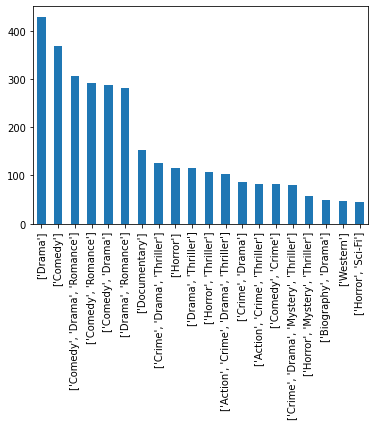

In [13]:
dataTraining.genres.value_counts()[:20].sort_values(ascending=False).plot(kind = 'bar')

### **TfidfVectorizer para las variables *plot*, *title* y *year***

Con la función TfidVectorizer se construyeron los token por palabra y se calculó la frecuencia relativa. Adicionalmente, en la función se incluyó el parámetro de stopwords, la cual se complementa con una lista de las palabras de menor frecuencia, con acentos especiales y números identificados en el plot y el título. 

Adicionalmente, a la función se incluye los parámetros:

-min_df = 4 (En la matriz x únicamente se incluye las palabras que aparecen mínimo 4 veces en toda la muestra de películas)


-ngram_range=(1, 2) (Se incluyen las series de palabras que aparecen de manera conjunta en el texto, en este caso hasta 2 palabras continuas) 

-sublinear_tf='bool' 

#### **Variable *plot***
Estandarizar el texto de la variable *plot*, se convierten las palabras en minúsculas, se eliminan signos de puntuación, se construye la función para sacar la raíz de las palabras y finalmente se aplica la función de Tdifvectorizer.

In [14]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
plots = dataTraining['plot']

# Remplazamos los signos de puntuación (hay casos en los que se tienen signos de puntuación pegados a las palabras)
for i in range(0,len(punctuation)):
  df['plot'] = df['plot'].str.replace(punctuation[i],'')

#Enviamos todo a minúsculas
df['plot'] = df['plot'].str.lower()

#Lematizamos (Volvemos al verbo (Significado))
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

#Sacar el Lemma de las palabras
def lemmatize_text(text):
  return ','.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]).replace(',',' ')

#Sacar la raíz de las palabras
def raiz(text):
  return ','.join([stemmer.stem(w) for w in w_tokenizer.tokenize(text)]).replace(',',' ')


df['plot'] = df['plot'].apply(raiz)
df['plot']

0        most is the stori of a singl father who take h...
1        a serial killer decid to teach the secret of h...
2        in sweden a femal blackmail with a disfigur fa...
3        in a friday afternoon in new york the presid o...
4        in los angel the editor of a publish hous caro...
                               ...                        
11263    in bangkok an assassin who turn down a job tha...
11265    eleven separ vignett are present in each celeb...
11269    joey evan is charm handsom funni talent and a ...
11270    when the sing veggi encount some car troubl th...
11275    a genet mutat dog is stolen from the lab of ma...
Name: plot, Length: 11261, dtype: object

In [15]:
# create a document-term matrix using TF-IDF
vect = TfidfVectorizer(   min_df=4, stop_words=my_stopwords, ngram_range=(1, 2), sublinear_tf='bool' )
dtm = vect.fit_transform(df['plot'])
datatf = pd.DataFrame(vect.fit_transform(df['plot']).toarray(), columns=[str(col)+'_pl' for col in vect.get_feature_names()])

dtm_train = datatf.iloc[:len(dataTraining),:]
dtm_kaggle = datatf.iloc[len(dataTraining):,:]

#Lista de palabras en X
print('Lista de palabras en X 1: ', vect.get_feature_names())

Lista de palabras en X 1:  ['abandon', 'abandon boy', 'abandon build', 'abandon famili', 'abandon father', 'abandon hous', 'abandon mother', 'abbey', 'abbi', 'abbott', 'abdomen', 'abduct', 'abductor', 'abe', 'abel', 'abhor', 'abhorr', 'abid', 'abigail', 'abil', 'abil chang', 'abil see', 'abl', 'abl achiev', 'abl carri', 'abl control', 'abl convinc', 'abl eke', 'abl escap', 'abl find', 'abl fulfil', 'abl get', 'abl give', 'abl handl', 'abl infiltr', 'abl keep', 'abl live', 'abl make', 'abl pay', 'abl piec', 'abl provid', 'abl save', 'abl see', 'abl stay', 'abl stop', 'abl surviv', 'abl take', 'abl track', 'abl use', 'abner', 'aboard', 'aboard ship', 'abolish', 'abomin', 'abort', 'abound', 'abov', 'abov ground', 'abraham', 'abraham lincoln', 'abram', 'abras', 'abroad', 'abrupt', 'abscond', 'absenc', 'absent', 'absolut', 'absorb', 'abstract', 'absurd', 'abu', 'abus', 'abus boyfriend', 'abus father', 'abus humili', 'abus husband', 'abus mother', 'abyss', 'academ', 'academi', 'academi award

In [16]:
#Lista de palabras en X
print('Lista de palabras en plot: ', vect.get_feature_names())

#Suma de frecuencia relativa por token de títulos
df_plot = dtm .toarray().sum(axis=0)
df_plot= pd.DataFrame(df_plot.reshape(1, datatf.shape[1]), columns=vect.get_feature_names())
df_plot=df_plot.transpose()
df_plot.sort_values(by=0, ascending=False)[:10]

Lista de palabras en plot:  ['abandon', 'abandon boy', 'abandon build', 'abandon famili', 'abandon father', 'abandon hous', 'abandon mother', 'abbey', 'abbi', 'abbott', 'abdomen', 'abduct', 'abductor', 'abe', 'abel', 'abhor', 'abhorr', 'abid', 'abigail', 'abil', 'abil chang', 'abil see', 'abl', 'abl achiev', 'abl carri', 'abl control', 'abl convinc', 'abl eke', 'abl escap', 'abl find', 'abl fulfil', 'abl get', 'abl give', 'abl handl', 'abl infiltr', 'abl keep', 'abl live', 'abl make', 'abl pay', 'abl piec', 'abl provid', 'abl save', 'abl see', 'abl stay', 'abl stop', 'abl surviv', 'abl take', 'abl track', 'abl use', 'abner', 'aboard', 'aboard ship', 'abolish', 'abomin', 'abort', 'abound', 'abov', 'abov ground', 'abraham', 'abraham lincoln', 'abram', 'abras', 'abroad', 'abrupt', 'abscond', 'absenc', 'absent', 'absolut', 'absorb', 'abstract', 'absurd', 'abu', 'abus', 'abus boyfriend', 'abus father', 'abus humili', 'abus husband', 'abus mother', 'abyss', 'academ', 'academi', 'academi awar

,0
find,164.535659
one,161.439943
get,156.108482
life,152.557226
new,138.247490
friend,135.239591
year,128.556031
man,126.748109
love,126.206117
live,125.275734


In [17]:
dtm_train.tail()

,abandon_pl,abandon boy_pl,abandon build_pl,abandon famili_pl,abandon father_pl,abandon hous_pl,abandon mother_pl,abbey_pl,abbi_pl,abbott_pl,abdomen_pl,abduct_pl,abductor_pl,abe_pl,abel_pl,abhor_pl,abhorr_pl,abid_pl,abigail_pl,abil_pl,abil chang_pl,abil see_pl,abl_pl,abl achiev_pl,abl carri_pl,abl control_pl,abl convinc_pl,abl eke_pl,abl escap_pl,abl find_pl,abl fulfil_pl,abl get_pl,abl give_pl,abl handl_pl,abl infiltr_pl,abl keep_pl,abl live_pl,abl make_pl,abl pay_pl,abl piec_pl,...,younger brother_pl,younger daughter_pl,younger man_pl,younger sibl_pl,younger sister_pl,younger son_pl,younger version_pl,younger woman_pl,youngest_pl,youngest daughter_pl,youngest son_pl,youngest three_pl,youngster_pl,youth_pl,youtub_pl,yuppi_pl,yuri_pl,zach_pl,zachari_pl,zack_pl,zane_pl,zani_pl,zealand_pl,zealous_pl,zebra_pl,zed_pl,zeke_pl,zen_pl,zero_pl,zero toler_pl,zeus_pl,zion_pl,zoe_pl,zoey_pl,zombi_pl,zone_pl,zoo_pl,zoologist_pl,zoom_pl,zorro_pl
7873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### **Variable *title***
Estandarizar el texto de la variable *title*, se convierten las palabras en minúsculas, se eliminan signos de puntuación, se construye la función para sacar la raíz de las palabras y finalmente se aplica la función de TdifVectorizer.

In [18]:
 # Remplazamos los signos de puntuación (hay casos en los que se tienen signos de puntuación pegados a las palabras)
for i in range(0,len(punctuation)):
  df['title'] = df['title'].str.replace(punctuation[i],'')

#Enviamos todo a minúsculas
df['title'] = df['title'].str.lower()

#Lematizamos (Volvemos al verbo (Significado))
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
  return ','.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]).replace(',',' ')

df['title'] = df['title'].apply(raiz)
df['title']

0                             most
1        how to be a serial killer
2                     a woman face
3                      execut suit
4                    narrow margin
                   ...            
11263            the fifth command
11265           coffe and cigarett
11269                     pal joey
11270       jonah a veggietal movi
11275              man best friend
Name: title, Length: 11261, dtype: object

In [19]:
vect2 = TfidfVectorizer(   min_df=4, stop_words=my_stopwords, ngram_range=(1, 2), sublinear_tf='bool' )
dtm2 = vect2.fit_transform(df['title'])
datatf2 = pd.DataFrame(vect2.fit_transform(df['title']).toarray(),  columns=[str(col)+'_ti' for col in vect2.get_feature_names()])

dtm_train2 = datatf2.iloc[:len(dataTraining),:]
dtm_kaggle2 = datatf2.iloc[len(dataTraining):,:]

In [20]:
#Lista de palabras en X
print('Lista de palabras en X 1: ', vect2.get_feature_names())

#Suma de frecuencia relativa por token de títulos
df_title = dtm2.toarray().sum(axis=0)
df_title= pd.DataFrame(df_title.reshape(1, datatf2.shape[1]) , columns=vect2.get_feature_names())
df_title=df_title.transpose()
df_title.sort_values(by=0, ascending=False)[:10]

Lista de palabras en X 1:  ['abbott', 'abbott costello', 'abov', 'academi', 'ace', 'across', 'act', 'action', 'activ', 'adam', 'addict', 'adult', 'adventur', 'affair', 'africa', 'afternoon', 'age', 'air', 'airport', 'alexand', 'ali', 'alic', 'alien', 'aliv', 'alley', 'alon', 'along', 'alway', 'amaz', 'america', 'american', 'american ninja', 'amityvill', 'anatomi', 'angel', 'angri', 'ani', 'anim', 'anna', 'anni', 'anoth', 'anyth', 'apart', 'ape', 'apocalyps', 'arm', 'armi', 'around', 'arrow', 'art', 'arthur', 'artist', 'ass', 'assassin', 'astronaut', 'atlas', 'attack', 'august', 'aveng', 'away', 'babe', 'babi', 'babysitt', 'bachelor', 'back', 'bad', 'bad boy', 'bad news', 'baker', 'ball', 'ballad', 'band', 'bandit', 'bang', 'bank', 'bar', 'barefoot', 'bat', 'batman', 'battl', 'bay', 'beach', 'bear', 'beast', 'beat', 'beauti', 'bee', 'beer', 'befor', 'begin', 'behind', 'believ', 'bell', 'bend', 'beneath', 'best', 'best friend', 'best man', 'better', 'betti', 'bever', 'bever hill', 'beyon

,0
man,123.536097
love,92.222656
night,74.148988
day,65.926023
girl,64.231290
dead,61.844894
movi,56.191508
last,55.841073
american,53.454719
life,52.646043


In [21]:
dtm_train2.tail()

,abbott_ti,abbott costello_ti,abov_ti,academi_ti,ace_ti,across_ti,act_ti,action_ti,activ_ti,adam_ti,addict_ti,adult_ti,adventur_ti,affair_ti,africa_ti,afternoon_ti,age_ti,air_ti,airport_ti,alexand_ti,ali_ti,alic_ti,alien_ti,aliv_ti,alley_ti,alon_ti,along_ti,alway_ti,amaz_ti,america_ti,american_ti,american ninja_ti,amityvill_ti,anatomi_ti,angel_ti,angri_ti,ani_ti,anim_ti,anna_ti,anni_ti,...,wild_ti,wilder_ti,willi_ti,win_ti,wind_ti,window_ti,wing_ti,winni_ti,winni pooh_ti,winter_ti,wire_ti,wish_ti,wit_ti,witch_ti,within_ti,without_ti,wive_ti,wizard_ti,wolf_ti,woman_ti,women_ti,wonder_ti,wonderland_ti,wood_ti,word_ti,work_ti,world_ti,wreck_ti,wrong_ti,xmen_ti,yard_ti,year_ti,yellow_ti,yes_ti,york_ti,young_ti,zero_ti,zombi_ti,zone_ti,zorro_ti
7873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### **Variable *year***

In [22]:
len(dataTraining)

7878

In [23]:
dtm4 = df['year']

dtm_train4 = dtm4.iloc[:len(dataTraining)]
dtm_kaggle4 = dtm4.iloc[len(dataTraining):]

In [24]:
dtm_train4

0       2003
1       2008
2       1941
3       1954
4       1990
        ... 
7890    2010
7891    1984
7892    1955
7893    1982
7894    2009
Name: year, Length: 7878, dtype: int64

#### **Variable *title + plot* concatenada**

Se crea una nueva variable en la cual se concatena el texto de las variables title y plot en una sola columna. 

Estandarizar el texto de la variable *title + plot*, se convierten las palabras en minúsculas, se eliminan signos de puntuación, se construye la función para sacar la raíz de las palabras y finalmente se aplica la función de TdifVectorizer.



In [25]:

from nltk.stem import WordNetLemmatizer 
wordnet_lemmatizer = WordNetLemmatizer()

df['pl_ti'] =df['title']+ ' ' +df['plot'] 
# Remplazamos los signos de puntuación (hay casos en los que se tienen signos de puntuación pegados a las palabras)
for i in range(0,len(punctuation)):
  df['pl_ti'] = df['pl_ti'].str.replace(punctuation[i],'')

#Enviamos todo a minúsculas
df['pl_ti']= df['pl_ti'].str.lower()

#Lematizamos (Volvemos al verbo (Significado))
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemma(text):
    words = text.split() #separa las palabras cada vez que hay un espacio
    return [wordnet_lemmatizer.lemmatize(word) for word in words] #le saca el lema de cada palabra

df['pl_ti']= df['pl_ti'].apply(raiz)
df['pl_ti']

vect3 = TfidfVectorizer( min_df=4, stop_words=my_stopwords, ngram_range=(1, 2), sublinear_tf='bool' )
tf_transformer = vect3.fit(df['pl_ti'])
dtm3 = vect3.fit_transform(df['pl_ti'])
datatf3 = pd.DataFrame(vect3.fit_transform(df['pl_ti']).toarray(),  columns=vect3.get_feature_names())

dtm_train3 = datatf3.iloc[:len(dataTraining),:]
dtm_kaggle3 = datatf3.iloc[len(dataTraining):,:]
datatf3.head()
datatf3.shape

(11261, 28368)

In [26]:
print('Lista de palabras en plot_title: ', vect3.get_feature_names())

Lista de palabras en plot_title:  ['abandon', 'abandon boy', 'abandon build', 'abandon famili', 'abandon father', 'abandon hous', 'abandon mother', 'abbey', 'abbi', 'abbott', 'abbott costello', 'abc', 'abdomen', 'abduct', 'abductor', 'abe', 'abel', 'abhor', 'abhorr', 'abid', 'abigail', 'abil', 'abil chang', 'abil see', 'abl', 'abl achiev', 'abl carri', 'abl control', 'abl convinc', 'abl eke', 'abl escap', 'abl find', 'abl fulfil', 'abl get', 'abl give', 'abl handl', 'abl infiltr', 'abl keep', 'abl live', 'abl make', 'abl pay', 'abl piec', 'abl provid', 'abl save', 'abl see', 'abl stay', 'abl stop', 'abl surviv', 'abl take', 'abl track', 'abl use', 'abner', 'aboard', 'aboard ship', 'abolish', 'abomin', 'abort', 'abound', 'abov', 'abov ground', 'abra', 'abraham', 'abraham lincoln', 'abram', 'abroad', 'abrupt', 'abscond', 'absenc', 'absent', 'absent father', 'absolut', 'absorb', 'abstract', 'absurd', 'abu', 'abus', 'abus boyfriend', 'abus father', 'abus humili', 'abus husband', 'abus moth

#### **Unificar bases: *plot, title* y *year***

In [27]:
#Validar el tamaño de cada base
print( 'plott: ', dtm_train.shape, dataTraining.shape)
print( 'plotk: ', dtm_kaggle.shape, datakaggle.shape)

print( 'titlet: ',dtm_train2.shape, dataTraining.shape)
print( 'titletk: ',dtm_kaggle2.shape, datakaggle.shape)

print( 'pl_ti: ',dtm_train3.shape, dataTraining.shape)
print( 'pl_ti: ',dtm_kaggle3.shape, datakaggle.shape)

print( 'añot: ',dtm_train4.shape, dataTraining.shape)
print( 'añok: ',dtm_kaggle4.shape, datakaggle.shape)

plott:  (7878, 27945) (7878, 7)
plotk:  (3383, 27945) (3383, 4)
titlet:  (7878, 1381) (7878, 7)
titletk:  (3383, 1381) (3383, 4)
pl_ti:  (7878, 28368) (7878, 7)
pl_ti:  (3383, 28368) (3383, 4)
añot:  (7878,) (7878, 7)
añok:  (3383,) (3383, 4)


In [28]:
#Unificar las variables de plot y title de forma independiente en una sola base

dff= pd.concat([dtm_train, dtm_train2], axis=1, sort=False)
dff.tail()

,abandon_pl,abandon boy_pl,abandon build_pl,abandon famili_pl,abandon father_pl,abandon hous_pl,abandon mother_pl,abbey_pl,abbi_pl,abbott_pl,abdomen_pl,abduct_pl,abductor_pl,abe_pl,abel_pl,abhor_pl,abhorr_pl,abid_pl,abigail_pl,abil_pl,abil chang_pl,abil see_pl,abl_pl,abl achiev_pl,abl carri_pl,abl control_pl,abl convinc_pl,abl eke_pl,abl escap_pl,abl find_pl,abl fulfil_pl,abl get_pl,abl give_pl,abl handl_pl,abl infiltr_pl,abl keep_pl,abl live_pl,abl make_pl,abl pay_pl,abl piec_pl,...,wild_ti,wilder_ti,willi_ti,win_ti,wind_ti,window_ti,wing_ti,winni_ti,winni pooh_ti,winter_ti,wire_ti,wish_ti,wit_ti,witch_ti,within_ti,without_ti,wive_ti,wizard_ti,wolf_ti,woman_ti,women_ti,wonder_ti,wonderland_ti,wood_ti,word_ti,work_ti,world_ti,wreck_ti,wrong_ti,xmen_ti,yard_ti,year_ti,yellow_ti,yes_ti,york_ti,young_ti,zero_ti,zombi_ti,zone_ti,zorro_ti
7873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
print(dff.shape)

(7878, 29326)


### **Crear y**

In [30]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))
le = MultiLabelBinarizer()
y = le.fit_transform(dataTraining['genres'])
y.shape

(7878, 24)

In [31]:
print(y.shape)
print(dff.shape)

(7878, 24)
(7878, 29326)


### **Bases de entrenamiento**
Crear base de entrenamiento 80% train y 20% test

In [32]:
#Base con las 2 variables 
X_train, X_test, y_train, y_test = train_test_split(dff, y, test_size=0.2, random_state=42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(6302, 29326) (6302, 24)
(1576, 29326) (1576, 24)


In [33]:
#Base únicamente con plot y train concatenado
X_train3, X_test3, y_train3, y_test3 = train_test_split(dtm_train3, y, test_size=0.2, random_state=42)
print(X_train3.shape,y_train3.shape)
print(X_test3.shape,y_test3.shape)

(6302, 28368) (6302, 24)
(1576, 28368) (1576, 24)


### **Entrenar modelo con 80% train y 20% test con plot y title concatenados**
Al entrenar el modelo con 80% train y 20% test, se obtiene un AUC de 0,904. Usando como input la variable plot y title de forma independiente



In [34]:
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


clf = OneVsRestClassifier(LogisticRegression(solver = 'lbfgs'))

In [35]:
from sklearn import metrics

clf.fit(X_train3, y_train3)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [36]:
from sklearn.metrics import r2_score, roc_auc_score

y_pred = clf.predict_proba(X_test3)
roc_auc_score(y_true = y_test3, y_score = y_pred, average='macro')

0.9047654411761458

### **Entrenar modelo con la base completa, con las variables plot y title concatenadas** 




In [37]:
from sklearn import metrics

clf.fit(dtm_train3, y)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [38]:
from sklearn.metrics import r2_score, roc_auc_score

y_pred = clf.predict_proba(dtm_train3)
roc_auc_score(y_true = y, y_score = y_pred, average='macro')

0.9871742487897684

### **Predicción del DataSet de Kaggle**

Ejecutar modelo de regresiones logísticas a la base kaggle, con el cual se obtiene un resultado de 0,903 en el promedio del AUC.

In [39]:
cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = clf.predict_proba(dtm_kaggle3)

In [40]:
res = pd.DataFrame(y_pred_test_genres, index=datakaggle.index, columns=cols)

In [47]:
res.head()

,p_Action,p_Adventure,p_Animation,p_Biography,p_Comedy,p_Crime,p_Documentary,p_Drama,p_Family,p_Fantasy,p_Film-Noir,p_History,p_Horror,p_Music,p_Musical,p_Mystery,p_News,p_Romance,p_Sci-Fi,p_Short,p_Sport,p_Thriller,p_War,p_Western
1,0.101402,0.088162,0.027134,0.026874,0.335259,0.129159,0.028207,0.599272,0.057089,0.089575,0.022437,0.023388,0.082656,0.025321,0.030620,0.110420,0.000859,0.454060,0.053147,0.010822,0.023476,0.176181,0.022593,0.026364
4,0.133845,0.040588,0.026659,0.147007,0.227228,0.267025,0.068231,0.767499,0.042558,0.027574,0.016658,0.040296,0.089948,0.030284,0.031047,0.044510,0.000989,0.084432,0.025803,0.011883,0.034492,0.249980,0.053220,0.023418
5,0.072778,0.028218,0.012091,0.054154,0.092910,0.590845,0.025605,0.820351,0.022976,0.036149,0.052976,0.029387,0.061212,0.023211,0.017368,0.345087,0.000889,0.176121,0.039791,0.008120,0.024272,0.549361,0.034551,0.017720
6,0.117522,0.092112,0.021094,0.048751,0.164198,0.092242,0.029743,0.714324,0.050661,0.047651,0.037170,0.050587,0.101151,0.024561,0.032149,0.090384,0.000894,0.216398,0.101638,0.008745,0.027510,0.333168,0.066671,0.024953
7,0.069302,0.077477,0.035562,0.031888,0.228882,0.085355,0.041310,0.247926,0.061779,0.116994,0.028655,0.017935,0.556999,0.023667,0.022228,0.088337,0.000871,0.106937,0.434385,0.011718,0.016004,0.288184,0.017712,0.019738


In [48]:
res.to_csv('Data_kaggle_contest.csv', index_label='ID')
from google.colab import files
files.download("Data_kaggle_contest.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>